In [1]:
from tools import constants

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib
plt.style.use("seaborn-poster")

# Functions

In [2]:
def h2_mass_fraction_calculator(
    local_density_scale_height, 
    density, 
    metallicity, 
    clumping_factor
):

    print("I am in the function h2_mass_fraction_calculator") 


    """This function is used to calculate the H2 mass fraction by using the formula 1 in the paper:
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    Arguments:
    ----------
    local_density_scale_height: array_like
        In this equation smooting length of the gas is assumed to be accurate estimation of the local density scale height. 
        Therefore smooting length is used instead of local density scale height
        [kpc]

    density: array_like
        Density of the gas particles
        [1e10 M☉ / kpc^3]

    metallicity: array_like
        metallicity of the gas particles 
        [Zsolar]

    clumping_factor: double or int
        It is a parameter to boost the h2 mass fraction and therefore h2 column density and CO luminosity
        [unitless]

    Returns:
    ----------
    h2_mass_fraction: array_like
        h2_mass_fraction = h2_gas_mass / total_gas_mass
        [unitless]

    column_density: array_like
        It is the column density considering all elements in the gas particle
        [gr/cm^2]

    dust_optical_depth: array_like	
        tau_c in the reference paper. It was being output in order to control the code
        [unitless]

    References: 
    -----------
    A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)

    """	

    # The unit of density in snapshots is [10^10 M_sun / kpc^3]
    density = density * 1e10  # [M_sun / kpc^3]
    density = density * constants.M_sun2gr / constants.kpc2cm**3  # [gr / cm^3]

    # The units of local_density_scale_height is kpc 
    local_density_scale_height = local_density_scale_height * constants.kpc2cm 	# [cm]

    # Calculation of column density 
    column_density = density * local_density_scale_height 	# [gr / cm^2]
    # Column density is the summation sign in the paper
    # Gunjan assumed that local density scale height is same with the smoooting length of the gas particles. I will continue on this assumption
    # but I don't know how it works

    # Calculation of dust cross section (sigma_d in txhe paper)
    dust_cross_section_per_H_nucleus_normalized_to_1eminus21 = metallicity
    dust_cross_section = dust_cross_section_per_H_nucleus_normalized_to_1eminus21 * 1e-21	# [cm^2]


    # Calculation of dust optical depth (tau_c in the paper)
    # mu_h is the mean mass per H nucleus
    mu_h = 2.3e-24	# [gr] 
    # clumping factor is used to increase the H2 formation to account for density inhomogeneities that are unresolved on the computational grid
    # since the H2 formation rate varies as the square of density, these inhomogeneities increase the overall rate
    dust_optical_depth = column_density * dust_cross_section / mu_h 	# [dimensionless]	

    # Calculation for scaled radiation field (chi in the paper) Eq 4 
    # This scaled radiation field will not likely to hold cell-by-cell every time step, but it should hold on average
    # clumping factor is used to boost the formation rate of the H2 molecules on dust grains (the R term)	
    scaled_radiation_field = 3.1 * (1 + 3.1 * metallicity**0.365) / (4.1 * clumping_factor)  # [dimensionless]

    # Calculation for s in the paper (Eq 2)
    s = np.log(1 + 0.6*scaled_radiation_field + 0.01 * np.power(scaled_radiation_field,2)) / ( 0.6 * dust_optical_depth )

    # Calculation for the H2 mass fraction (f_H2 in the paper Eq 1)
    h2_mass_fraction = 1 - (3/4) * (s / (1 + 0.25*s))	# [dimensionless]
    h2_mass_fraction[h2_mass_fraction < 0] = 0 		# If the result is negative set it to zero
    
    # Set inf values to NaN
    # Replace inf/-inf with NaN
    h2_mass_fraction[np.isinf(h2_mass_fraction)] = np.nan
    column_density[np.isinf(column_density)] = np.nan    
    dust_optical_depth[np.isinf(dust_optical_depth)] = np.nan    
    scaled_radiation_field[np.isinf(scaled_radiation_field)] = np.nan    
    dust_optical_depth[np.isinf(dust_optical_depth)] = np.nan    
    
    return h2_mass_fraction, column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth


def X_co_calculator(
    h2_column_density, 
    metallicity, 
):
    print("I am in the function X_co_calculator")

    """This function is being used in order to calculate the X_co for each annulus

    Arguments:
    ----------
    h2_column_density: array-like
        h2_column_density for each particle 
        [gr/cm^2]

    metallicity: array-like
        [Zsolar]

    Returns:
    ----------
    X_co: vector 
        CO conversion factor for each particle
        [cm^-2 /K-km s^-1]
        
    X_co_solar_metallicity: vector
        X_co when metallicity is set to solar metallicity
        [cm^-2 /K-km s^-1]

    References: 
    -----------
    A general model for the CO-H2 conversion factor in galaxies with applications to the star formation law. (Narayanan et al. 2012)

    """	


    h2_column_density = h2_column_density * constants.gr2M_sun / (constants.cm2pc)**2	
    # h2_column_density [M_sun/pc^2]

    # A general model for the CO-H2 conversion factor in galaxies with applications to the star formation law. (Narayanan et al. 2012)
    # Eq 6 

    X_co = 1.3e21/(metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]

    ####	

    X_co_solar_metallicity = 1.3e21/(constants.solar_metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]

    # Set inf values to NaN
    # Replace inf/-inf with NaN
    X_co[np.isinf(X_co)] = np.nan
    X_co_solar_metallicity[np.isinf(X_co_solar_metallicity)] = np.nan
    
    
    return X_co, X_co_solar_metallicity

# main

In [3]:
galaxy_name = "m12i_res7100_md"
galaxy_type = "zoom_in"
redshift = "0.0"

# galaxy_name = "gal0"
# galaxy_type = "firebox"
# redshift = "0.0"


In [4]:
# Read cloudy_gas_txt 
cloudy_gas_particles_file_directory = f"/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/{galaxy_type}/z{redshift}/{galaxy_name}/trial1" 


# Define the column names based on your description
gas_column_names = [
    "x", 
    "y", 
    "z", 
    "smoothing_length", 
    "mass", 
    "metallicity", # Zsolar but will be converted to mass fraction in the future
    "temperature", 
    "vx", 
    "vy", 
    "vz", 
    "hden", 
    "radius", 
    "sfr", 
    "turbulence", 
    "density", 
    "mu_theoretical", 
    "average_sobolev_smoothingLength",
    "index", 
    "isrf"
]


gas_particles_df = pd.read_csv(
    f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt",
    delim_whitespace=True, 
    comment='#', 
    names=gas_column_names
)


# Converting density back to 1e10 Msolar / kpc^3 from gr/cm^3
# gas_particles_df["density"] *= (1 / (1e10 * constants.M_sun2gr)) * (constants.kpc2cm)**3  # 1e10 Msolar / kpc^3 
gas_particles_df["density"] /= (1e10 * constants.M_sun2gr / (constants.kpc2cm)**3)  # 1e10 Msolar / kpc^3


print(f"{cloudy_gas_particles_file_directory}/cloudy_gas_particles.txt read and dataframe is created!")


star_column_names = [
    "x",
    "y",
    "z",
    "vx",
    "vy",
    "vz",
    "metallicity",
    "mass",
    "age"
]

star_particles_df = pd.read_csv(
    f"{cloudy_gas_particles_file_directory}/comprehensive_star.txt",
    delim_whitespace=True, 
    comment='#', 
    names=star_column_names
)

print(f"{cloudy_gas_particles_file_directory}/comprehensive_star.txt read and dataframe is created!")


/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/zoom_in/z0.0/m12i_res7100_md/trial1/cloudy_gas_particles.txt read and dataframe is created!
/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/zoom_in/z0.0/m12i_res7100_md/trial1/comprehensive_star.txt read and dataframe is created!


In [21]:
############################################################################################################################################

# h2 mass fraction is calculated by following Krumholz, and Gnedin (2011) 
# "A Comparison of Methods for Determining the Molecular Content of Model Galaxies by Krumholz, and Gnedin (2011)"

# from tools.functions import local_density_scale_height_calculator
# gas_particles_df["local_density_scale_height"] =  local_density_scale_height_calculator(
#     density_gas = np.array(gas_particles_df["density"]), 
#     x_gas = np.array(gas_particles_df["x"]), 
#     y_gas = np.array(gas_particles_df["y"]), 
#     z_gas = np.array(gas_particles_df["z"]), 
#     smoothing_length_gas = np.array(gas_particles_df["smoothing_length"])
# ) # pc 



h2_mass_fraction, gas_column_density, dust_optical_depth, scaled_radiation_field, s, dust_optical_depth = h2_mass_fraction_calculator(
    local_density_scale_height = np.array(gas_particles_df["average_sobolev_smoothingLength"]) / constants.kpc2pc, # kpc
    density = np.array(gas_particles_df["density"]), # 1e10 Msolar / kpc^3
    metallicity= np.array(gas_particles_df["metallicity"]),  # Zsolar
    clumping_factor = 1
)

# Find molecular gas mass
gas_particles_df["h2_mass"] = h2_mass_fraction * gas_particles_df["mass"] # Msolar

I am in the function h2_mass_fraction_calculator


In [22]:
# Findind the column density of gas particles. 
h2_column_density = h2_mass_fraction * gas_column_density  # [gr/cm^2]	

# Estimating the Xco of gas particles. 
gas_particles_df["Xco"], Xco_solar_metallicity = X_co_calculator(
    h2_column_density = h2_column_density,  # [gr / cm^2]
    metallicity = np.array(gas_particles_df["metallicity"]), # mass fraction
)

I am in the function X_co_calculator


/tmp/ipykernel_1642389/3458077065.py:142: RuntimeWarning: divide by zero encountered in true_divide
  X_co = 1.3e21/(metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]
/tmp/ipykernel_1642389/3458077065.py:146: RuntimeWarning: divide by zero encountered in true_divide
  X_co_solar_metallicity = 1.3e21/(constants.solar_metallicity * h2_column_density**0.5) #[cm^-2 /K-km s^-1]


In [23]:
# Calculating Lco
alfa_co = gas_particles_df["Xco"] / 6.3e19 # [M_solar/pc^-2 (K-km s^-1)^-1]

gas_particles_df["L_co"] = gas_particles_df["h2_mass"] / alfa_co

In [27]:
gas_particles_df.keys()

Index(['x', 'y', 'z', 'smoothing_length', 'mass', 'metallicity', 'temperature',
       'vx', 'vy', 'vz', 'hden', 'radius', 'sfr', 'turbulence', 'density',
       'mu_theoretical', 'average_sobolev_smoothingLength', 'index', 'isrf',
       'h2_mass', 'Xco', 'L_co'],
      dtype='object')

In [28]:
# Write to an output file 

# Chancing the unit of density once more to make it same with the cloudy gas particle file 
gas_particles_df["density"] *= (1e10 * constants.M_sun2gr / (constants.kpc2cm)**3)  # gr / cm^3


write_df = gas_particles_df[[
    "x",
    "y",
    "z",
    'smoothing_length', 
    'mass', 
    'metallicity', 
    'temperature',
    'vx', 
    'vy', 
    'vz', 
    'hden', 
    'radius', 
    'sfr', 
    'turbulence', 
    'density',
    'mu_theoretical', 
    'average_sobolev_smoothingLength', 
    'index', 
    'isrf',
    'h2_mass',
    'Xco',
    'L_co',
]]

# Write to a file 
header = f"""Gas particles for {galaxy_name} galaxy
Column 0: x-coordinate (pc)
Column 1: y-coordinate (pc)
Column 2: z-coordinate (pc)
Column 3: smoothing length (pc)
Column 4: mass (Msolar)
Column 5: metallicity (Zsolar)
Column 6: temperature (K)
Column 7: vx (km/s)
Column 8: vy (km/s)
Column 9: vz (km/s)
Column 10: hydrogen density (cm^-3)
Column 11: radius (pc)
Column 12: sfr (Msolar/yr)
Column 13: turbulence (km/s)
Column 14: density (gr/cm^-3)
Column 15: mu_theoretical (1)
Column 16: average_sobolev_smoothingLength (pc)    
Column 17: index (1)
Column 18: isrf [G0]
Column 19: h2 mass (Msolar)
Column 20: Xco (cm^-2 (K km s^-1)^-1)
Column 21: Lco (K km s^-1 pc^2)
"""

write_file_name = f"{cloudy_gas_particles_file_directory}/semi_analytical_average_sobolev_smoothingLength.txt"
np.savetxt(fname=write_file_name, X = write_df, fmt='%.8e', header=header)
print(f"{write_file_name} is written!") 


/mnt/raid-cita/dtolgay/FIRE/post_processing_fire_outputs/skirt/runs_hden_radius/zoom_in/z0.0/m12i_res7100_md/trial1/semi_analytical_average_sobolev_smoothingLength.txt is written!


In [30]:
# Counting the number of NaN elements
num_nan = np.sum(np.isnan(gas_particles_df["L_co"]))

print(len(gas_particles_df))

print("Number of NaN elements in the array:", num_nan)

2270462
Number of NaN elements in the array: 1709973


# Histogram plots

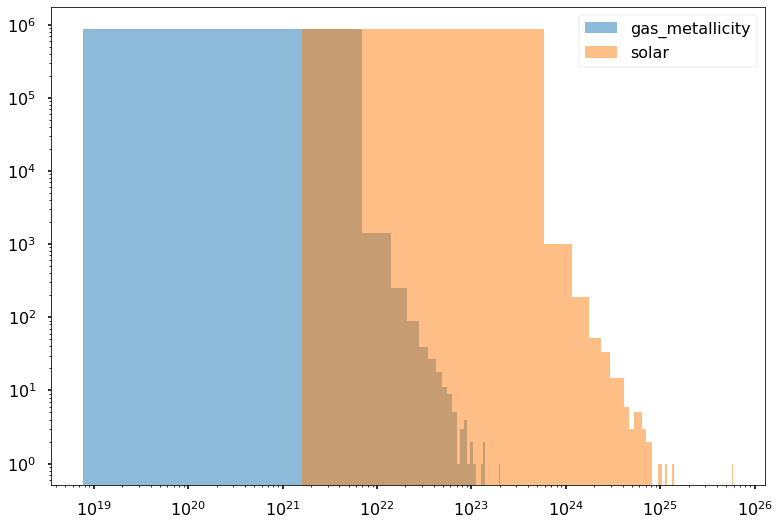

In [18]:
plt.hist(gas_particles_df["Xco"], bins=100 , label = "gas_metallicity", alpha = 0.5)
plt.hist(Xco_solar_metallicity, bins=100, label="solar", alpha = 0.5)
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

# Plotting Lco

In [19]:
from tools import functions_importing_observations as func_observations

################# Importing data from observations 

base_dir = "/mnt/raid-cita/dtolgay/Observations"
    
# ### Ly_alpha
# HETDEX_df = func_observations.hetdex_data_reading(f"/mnt/raid-cita/dtolgay/Observations/hetdex_sc1_v3.2.ecsv")
# hayes_2014 = func_observations.HAYES_2014_data_reading("/mnt/raid-cita/dtolgay/Observations/hayes_2014.xlsx")
# cowie_2011 = func_observations.cowie_2011_lya_reading("/mnt/raid-cita/dtolgay/Observations/cowie_2011_lya.xlsx")

### C0
xCOLDGASS_file_path = "/mnt/raid-cita/dtolgay/Observations/xCOLDGASS_PubCat.fits"
XCOLDGASS_df = func_observations.XCold_Gass_data_reading(filedir=xCOLDGASS_file_path)

PHIBSS2_file_path = "/mnt/raid-cita/dtolgay/Observations/PHIBSS2_data.xlsx" 
PHIBBS2_df = func_observations.PHIBSS2_data_reading(filedir=PHIBSS2_file_path)

ALMA_2019_file_path = "/mnt/raid-cita/dtolgay/Observations/ALMA_2019_data.xlsx"
ALMA_df = func_observations.ALMA_2019_Data_Reading(filedir=ALMA_2019_file_path)

Leroy_file_path = "/mnt/raid-cita/dtolgay/Observations/Leroy_data.xlsx"
Leroy_df, average_radius_r25_times_075_LEROY = func_observations.Leroy_Data_Reading(filedir=Leroy_file_path)


# ### h alpha
# young_1996 = func_observations.young_1996("/mnt/raid-cita/dtolgay/Observations/young_1996.xlsx")
# james_2014 = func_observations.james_2024("/mnt/raid-cita/dtolgay/Observations/james_2014_h_alpha.dat")

Laura_df = func_observations.laura_eyeballing_data_df_creator()

I am in the function XCold_Gass_data_reading
I am in the function PHIBSS2_data_reading
I am in the function ALMA_2019_Data_Reading
I am in the function Leroy_data_reading
average_radius_r25_times_075_LEROY:  8.886206896551723
I am in the function laura_eyeballing_data_df_creator


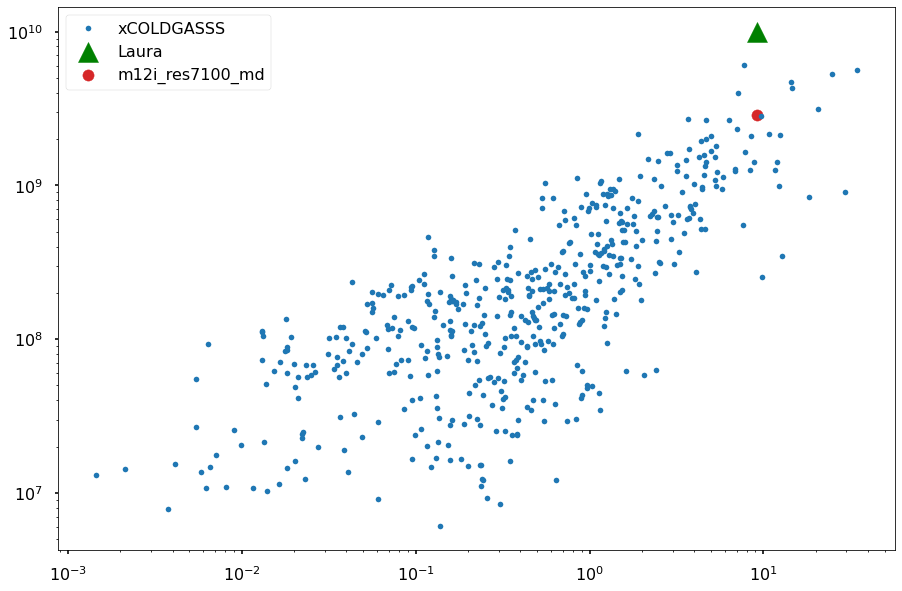

In [20]:
fig = plt.figure(figsize=(15, 10))

# xCOLDGASS
plt.plot(XCOLDGASS_df['SFR'], XCOLDGASS_df['Lco'], '.', label = "xCOLDGASSS")

# ## Xcoldgass metallicity color plot
# plt.scatter(XCOLDGASS_df['SFR'], XCOLDGASS_df['Lco'], c=np.log10(XCOLDGASS_df["Mh2"]), cmap="GnBu", label = "xCOLDGASSS") 
# plt.colorbar(label="log10_Mh2", orientation="horizontal") 


# Laura
plt.scatter(Laura_df["SFR"], Laura_df["Lco"], marker = '^', s=400, c = "Green", label = "Laura")

# My work
plt.scatter(sum(gas_particles_df["sfr"]), np.sum(gas_particles_df["L_co"]), c = "tab:Red", label = f"{galaxy_name}")

plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()